In [1]:
%load_ext autoreload
%autoreload 2

from imports import *
from models import *
from utils import *
from data import *
from configs import CONFIGS, EXP_CODES

plt.rcParams.update({'font.size': 22})

#### Training on some loops and some non-loops

100%|██████████| 5000/5000 [00:01<00:00, 4891.96it/s]


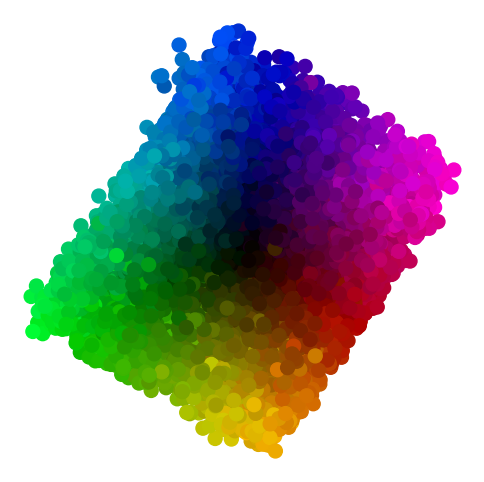

In [4]:
config_name = 'bird2d_someloops'
config = deepcopy(CONFIGS[config_name])

_, test_dataset, _, _ = get_dataset_dataloader(config)

'''
generate trajectory
'''
trajectory, gt_vs = test_dataset.generate_sample_trajectory(length=5000)

trajectory = trajectory.squeeze(dim=1)
gt_velocities = np.array(gt_vs)
colors = np.array(test_dataset.cmap(gt_vs))

assert gt_velocities.ndim == 2

# pad gt_velocities with necessary zeros
pad = np.zeros((gt_velocities.shape[0], config['model_args']['v_dim'] - gt_velocities.shape[1]))
gt_velocities = np.hstack((gt_velocities, pad))

if np.prod(pad.shape) == 0 and config['task_dim'] == 1:
    gt_velocities = np.hstack((gt_velocities, np.zeros((gt_velocities.shape[0], 1))))


model_code = EXP_CODES[config_name][0]

pred_velocities = our_reduction(
    trajectory,
    config,
    model_code,
)

error, transformed_pred_velocities = compute_error_metric(
    gt_velocities,
    pred_velocities,
)

fig = plt.figure(figsize=(6, 6))

ax = plt.gca()
ax.scatter(*pred_velocities.T, c=colors, s=100)
# ax.set_xlabel('dim 1')
# ax.set_ylabel('dim 2')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [5]:
print(error)

0.03469117923791841


In [8]:
fig.savefig('./figures/bird2d_someloops.png')

#### Training on only image pairs

100%|██████████| 5000/5000 [00:01<00:00, 4788.93it/s]


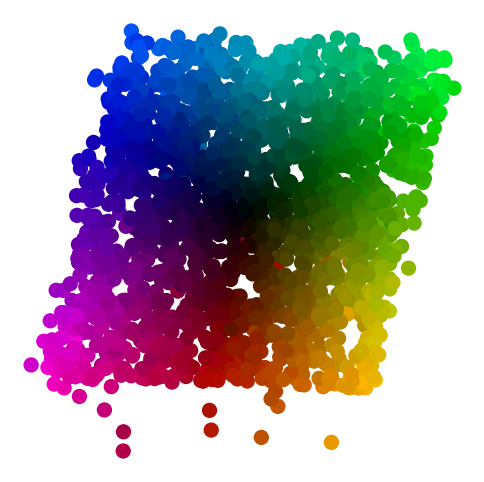

In [9]:
config_name = 'gauss_blobs_imagepairs'
config = deepcopy(CONFIGS[config_name])

_, test_dataset, _, _ = get_dataset_dataloader(config)

'''
generate trajectory
'''
trajectory, gt_vs = test_dataset.generate_sample_trajectory(length=2000)

trajectory = trajectory.squeeze(dim=1)
gt_velocities = np.array(gt_vs)
colors = np.array(test_dataset.cmap(gt_vs))

assert gt_velocities.ndim == 2

# pad gt_velocities with necessary zeros
pad = np.zeros((gt_velocities.shape[0], config['model_args']['v_dim'] - gt_velocities.shape[1]))
gt_velocities = np.hstack((gt_velocities, pad))

if np.prod(pad.shape) == 0 and config['task_dim'] == 1:
    gt_velocities = np.hstack((gt_velocities, np.zeros((gt_velocities.shape[0], 1))))


model_code = EXP_CODES[config_name][0]

pred_velocities = our_reduction(
    trajectory,
    config,
    model_code,
)

error, transformed_pred_velocities = compute_error_metric(
    gt_velocities,
    pred_velocities,
)

fig = plt.figure(figsize=(6, 6))

ax = plt.gca()
ax.scatter(*pred_velocities.T, c=colors, s=100)
# ax.set_xlabel('dim 1')
# ax.set_ylabel('dim 2')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [10]:
print(error)

0.01993709305481409


In [11]:
fig.savefig('./figures/gauss_blobs_imagepairs.png')

#### Simulating beyond reasonable boundaries

In [210]:
config_name = 'bird2d'
config = deepcopy(CONFIGS[config_name])

_, test_dataset, _, _ = get_dataset_dataloader(config)


with torch.no_grad():
    model_code = EXP_CODES[config_name][0]
    model = config['model_class'](seed=0, **config['model_args']).cuda()
    model.load_state_dict(torch.load('./models/model_{}.pt'.format(model_code)))
    _ = model.eval()


    trajectory, gt_vs = test_dataset.generate_sample_trajectory(length=10)
    
    frames = trajectory.cuda()

    ind = 0
    v = model.get_v(frames[ind, :], frames[ind + 1, :]).view(-1, 2)    


    all_frames = [frames[ind, :]]

    for _ in range(50):
        all_frames.append(normalize_label_tensor(model.get_i3(v, all_frames[-1])))

100%|██████████| 5000/5000 [00:01<00:00, 4850.65it/s]


In [211]:
def display_video(frames_tensor, fps=10):
    num_frames, height, width = frames_tensor.shape

    fig = plt.figure(figsize=(width / 20, height / 20))
    ax = plt.axes()

    # Define the function to update the frame
    def update(frame):
        ax.imshow(frames_tensor[frame], cmap='gray')
        ax.axis('off')

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=num_frames, interval=1000/fps)

    # Display the animation
    plt.close()
    return HTML(anim.to_jshtml())


display_video(torch.stack(all_frames).squeeze().cpu())

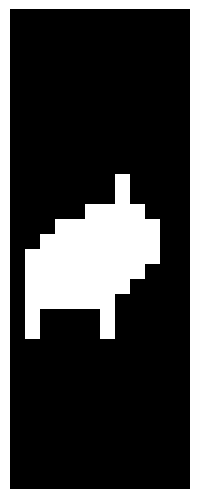

In [270]:
fig, ax = plt.subplots()

ax.imshow(all_frames[20].cpu().squeeze().numpy(), cmap='gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

fig.savefig('./figures/beyond_boundaries_figures/N.png', bbox_inches='tight', pad_inches=0)

#### Trajectories in PCA image space vs. model image space

In [14]:
config_name = 'gauss_blobs_3dim'
config = deepcopy(CONFIGS[config_name])

_, test_dataset, _, _ = get_dataset_dataloader(config)


'''
generate trajectory
'''
trajectory, gt_vs = test_dataset.generate_sample_trajectory(length=1000)

trajectory = trajectory.squeeze(dim=1)
gt_velocities = np.array(gt_vs)
colors = np.array(test_dataset.cmap(gt_vs))

assert gt_velocities.ndim == 2

# pad gt_velocities with necessary zeros
pad = np.zeros((gt_velocities.shape[0], config['model_args']['v_dim'] - gt_velocities.shape[1]))
gt_velocities = np.hstack((gt_velocities, pad))

if np.prod(pad.shape) == 0 and config['task_dim'] == 1:
    gt_velocities = np.hstack((gt_velocities, np.zeros((gt_velocities.shape[0], 1))))


model_code = EXP_CODES[config_name][1]

pred_velocities = our_reduction(
    trajectory,
    config,
    model_code,
)

pca_pred_velocities = pca_reduction(
    trajectory,
    config,
    3,
)

100%|██████████| 5000/5000 [00:00<00:00, 5003.30it/s]


In [18]:
pred_points = pred_velocities.cumsum(axis=0)
pca_points = pca_pred_velocities.cumsum(axis=0)

/tmp/ipykernel_3582889/3917704428.py:37: MatplotlibDeprecationWarning:

The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.



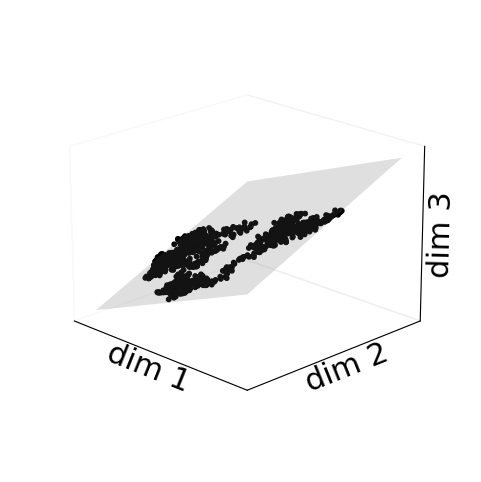

In [140]:
from sklearn.linear_model import LinearRegression


fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(projection='3d')

# show low-dim manifold
linear_model = LinearRegression()
linear_model.fit(pred_points[:, :2], pred_points[:, 2])
Z_pred = linear_model.predict(pred_points[:, :2])
min_bound, max_bound = pred_points.min(), pred_points.max()
xx, yy = np.meshgrid(np.linspace(min_bound, max_bound, 10), np.linspace(min_bound, max_bound, 10))
zz = linear_model.intercept_ + linear_model.coef_[0] * xx + linear_model.coef_[1] * yy
ax.plot_surface(xx, yy, zz, color='gray', alpha=0.2)  # Plane with low alpha

ax.scatter3D(*pred_points.T, c='black', s=10, alpha=1.0)
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.xaxis.labelpad=-11.5
ax.yaxis.labelpad=-11.5
ax.zaxis.labelpad=-11.5

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(elev=200, azim=225.0)

ax.dist = 12

fig.savefig('./figures/moving_blobs_model_image_space.png')

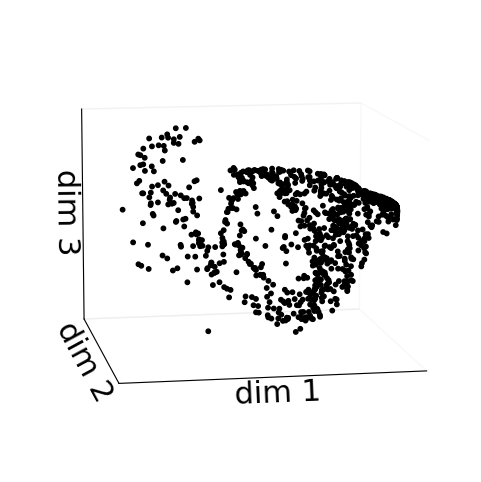

In [171]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')


ax.scatter3D(*pca_points.T, c='black', s=10, alpha=1.0)
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.xaxis.labelpad=-11.5
ax.yaxis.labelpad=-11.5
ax.zaxis.labelpad=-11.5

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(elev=190, azim=100.0)

fig.savefig('./figures/moving_blobs_pca_image_space.png')

In [180]:
T, H, W = trajectory.shape

pca = PCA()
embedding = pca.fit_transform(np.reshape(trajectory, (T, H * W)))

cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
num_components_95 = np.argmax(cumulative_variance_explained >= 0.95) + 1

print(f"Number of dimensions needed to explain 95% variance: {num_components_95}")

Number of dimensions needed to explain 95% variance: 24


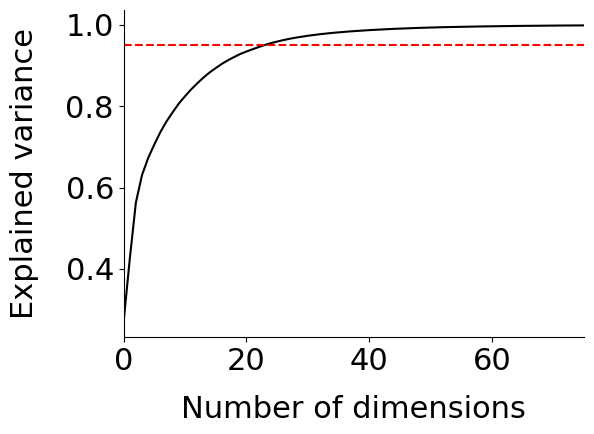

In [209]:
fig, ax = plt.subplots()

ax.plot(cumulative_variance_explained, color='black')
ax.plot([0, 75], [0.95, 0.95], 'r--')
ax.set_xlim([0, 75])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Number of dimensions')
ax.set_ylabel('Explained variance')

ax.xaxis.labelpad+=10.0
ax.yaxis.labelpad+=15.0

plt.tight_layout()

fig.savefig('./figures/moving_blobs_pca_image_space_explained_variance.pdf')